Copyright 2020, Martin Rudorfer.

In [0]:
# @title Licensed under the MIT License
# 
# Copyright (c) 2020 Martin Rudorfer
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

This notebook is dedicated to predicting heart failures from medical data.

We will:
1. inspect the data and suggest which features may be useful in heart failure prediction
2. preprocess the data
3. create a predictive model to detect patients who have
heart disease
4. evaluate the model to estimate its performance on unseen data

# 1. Loading and Inspecting the Dataset

We use the publicly available heart disease dataset (see https://archive.ics.uci.edu/ml/datasets/Heart+Disease) and more specifically the processed.cleveland.data set collected by V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

In [1]:
!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data \
    -O /tmp/cleveland.data

--2020-05-20 11:46:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [application/x-httpd-php]
Saving to: ‘/tmp/cleveland.data’

/tmp/cleveland.data 100%[===================>]  18.03K  --.-KB/s    in 0.1s    

2020-05-20 11:46:14 (131 KB/s) - ‘/tmp/cleveland.data’ saved [18461/18461]



We now import the data using pandas. A quick inspection of the raw data showed that there are NA values encoded as '?'.

In [2]:
import os
import numpy as np
import pandas as pd

data_file = os.path.join('/tmp/cleveland.data')
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
                        'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 
                        'ca', 'thal', 'num']
df = pd.read_csv(data_file, sep=',', na_values='?',
                 names=names)
df.head()

age  sex   cp  trestbps   chol  fbs  ...  exang  oldpeak  slope   ca  thal  num
0  63.0  1.0  1.0     145.0  233.0  1.0  ...    0.0      2.3    3.0  0.0   6.0    0
1  67.0  1.0  4.0     160.0  286.0  0.0  ...    1.0      1.5    2.0  3.0   3.0    2
2  67.0  1.0  4.0     120.0  229.0  0.0  ...    1.0      2.6    2.0  2.0   7.0    1
3  37.0  1.0  3.0     130.0  250.0  0.0  ...    0.0      3.5    3.0  0.0   3.0    0
4  41.0  0.0  2.0     130.0  204.0  0.0  ...    0.0      1.4    1.0  0.0   3.0    0

[5 rows x 14 columns]

In [0]:
display(df.describe())

age         sex          cp  ...          ca        thal         num
count  303.000000  303.000000  303.000000  ...  299.000000  301.000000  303.000000
mean    54.438944    0.679868    3.158416  ...    0.672241    4.734219    0.937294
std      9.038662    0.467299    0.960126  ...    0.937438    1.939706    1.228536
min     29.000000    0.000000    1.000000  ...    0.000000    3.000000    0.000000
25%     48.000000    0.000000    3.000000  ...    0.000000    3.000000    0.000000
50%     56.000000    1.000000    3.000000  ...    0.000000    3.000000    0.000000
75%     61.000000    1.000000    4.000000  ...    1.000000    7.000000    2.000000
max     77.000000    1.000000    4.000000  ...    3.000000    7.000000    4.000000

[8 rows x 14 columns]

To learn more about the nature of these features we can refer to the dataset's documentation:
- age: age in years 
- sex: sex (1 = male; 0 = female) 
- cp: chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
- trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
- chol: serum cholestoral in mg/dl 
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
- restecg: resting electrocardiographic results (0 = normal; 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV); 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- thalach: maximum heart rate achieved 
- exang: exercise induced angina (1 = yes; 0 = no) 
- oldpeak = ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)
- ca: number of major vessels (0-3) colored by flourosopy 
- thal (3 = normal; 6 = fixed defect; 7 = reversable defect)
- num: diagnosis of heart disease (angiographic disease status), 0 =  < 50% diameter narrowing; 1 =  > 50% diameter narrowing 

The last description is actually a bit misleading. We see that the values are in [0,...,4]. It seems that [1,2,3,4] are treated as [1]. Note that `num` is in fact the prediction target.

The other features can be grouped in categorical or continuous features.

In [0]:
# let's organize the features depending on whether they are of categorical or continuous nature
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
continuous = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [25]:
# replace num values above 1 to yield binary diagnosis
df['num'].values[df['num'] > 1] = 1

age  sex   cp  trestbps   chol  fbs  ...  exang  oldpeak  slope   ca  thal  num
0  63.0  1.0  1.0     145.0  233.0  1.0  ...    0.0      2.3    3.0  0.0   6.0    0
1  67.0  1.0  4.0     160.0  286.0  0.0  ...    1.0      1.5    2.0  3.0   3.0    1
2  67.0  1.0  4.0     120.0  229.0  0.0  ...    1.0      2.6    2.0  2.0   7.0    1
3  37.0  1.0  3.0     130.0  250.0  0.0  ...    0.0      3.5    3.0  0.0   3.0    0
4  41.0  0.0  2.0     130.0  204.0  0.0  ...    0.0      1.4    1.0  0.0   3.0    0

[5 rows x 14 columns]

Let us also check the class frequencies:

In [49]:
condition = df['num'].sum()
total = df['num'].count()

print(100 * condition / total, '% samples with heart disease')

45.87458745874587 % samples with heart disease


The dataset is well-balanced, which is good for training a predictive model.

Let's plot some of the features to learn how they relate to the diagnosis of heart disease.

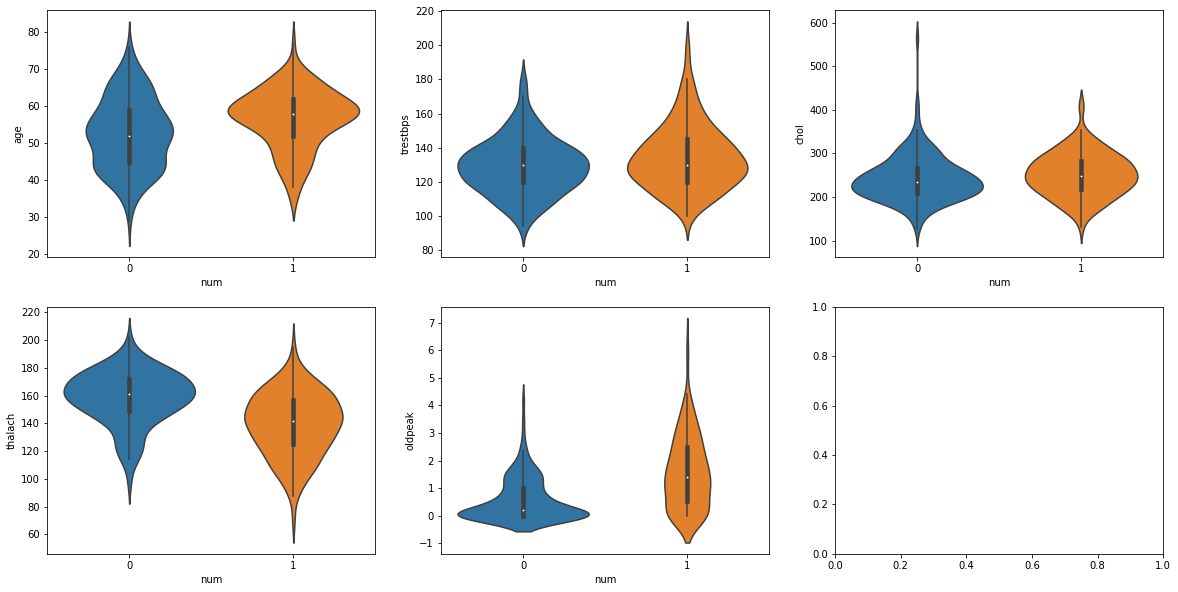

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

_, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(continuous):
  sns.violinplot(x='num', y=feature, data=df, ax=axes[i])

The charts indicate that `trestbps` and `chol` are least informative, whereas e.g. `thal` has a strong correlation with heart disease.

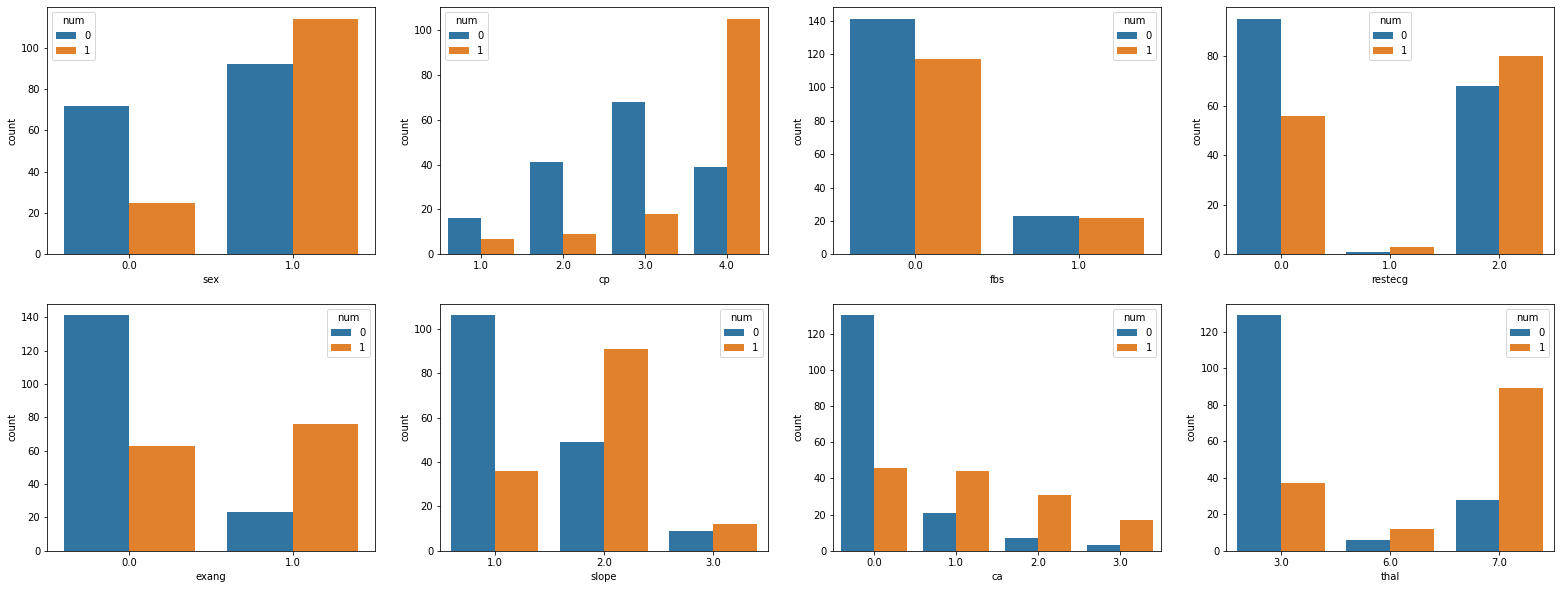

In [27]:
_, axes = plt.subplots(2, 4, figsize=(27, 10))
axes = axes.ravel()

for i, feature in enumerate(categorical):
  sns.countplot(x=feature, data=df, hue='num', ax=axes[i])

The charts for the categorical features indicate that especially `cp` and `ca` shall be discriminative features.
In contrast, `fbs` or also `restecg` will not help much in predicting heart disease.

# 2. Preprocessing

Now we can start preprocessing the data to be suitable for our predictive model.

We will first deal with the missing values.

In [8]:
# Rows with NA values:
display(df[df.isna().any(axis=1)])

age  sex   cp  trestbps   chol  ...  oldpeak  slope   ca  thal  num
87   53.0  0.0  3.0     128.0  216.0  ...      0.0    1.0  0.0   NaN    0
166  52.0  1.0  3.0     138.0  223.0  ...      0.0    1.0  NaN   3.0    0
192  43.0  1.0  4.0     132.0  247.0  ...      0.1    2.0  NaN   7.0    1
266  52.0  1.0  4.0     128.0  204.0  ...      1.0    2.0  0.0   NaN    1
287  58.0  1.0  2.0     125.0  220.0  ...      0.4    2.0  NaN   7.0    0
302  38.0  1.0  3.0     138.0  175.0  ...      0.0    1.0  NaN   3.0    0

[6 rows x 14 columns]

The affected columns are 'ca' and 'thal'. The description of the dataset states the following:
- ca: number of major vessels (0-3) colored by flourosopy 
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 

Almost all predictive models require a complete dataset. We could leave out affected samples or features, but that means wasting a lot of data. So instead we could try to guess the missing values. There are several possible ways we can accomplish this:
- Insert a baseline number (e.g. 0 for 'ca' or 3 for 'thal')
- Use the other samples to predict the most likely value, e.g. using a k-nearest-neighbor approach

We will go for the kNN approach.

Note that we have to normalize the dataset first in order to get reasonable results from the kNN imputer. We can switch between min/max and mean/std normalization.

In [50]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

# choose normalization method
MIN_MAX = True

if MIN_MAX:
  scaler = MinMaxScaler()
else:
  scaler = StandardScaler()

# normalize values (except prediction target)
columns = df.drop('num', axis=1).columns
df_norm = pd.DataFrame(scaler.fit_transform(df[columns]), columns=columns)

# apply the k-NN imputer (still not using prediction target)
imputer = KNNImputer(n_neighbors=5)
df_complete = pd.DataFrame(imputer.fit_transform(df_norm[columns]), columns=columns)
df_complete['num'] = df['num']

display(df_complete.head())

age  sex        cp  trestbps  ...  slope        ca  thal  num
0  0.708333  1.0  0.000000  0.481132  ...    1.0  0.000000  0.75    0
1  0.791667  1.0  1.000000  0.622642  ...    0.5  1.000000  0.00    1
2  0.791667  1.0  1.000000  0.245283  ...    0.5  0.666667  1.00    1
3  0.166667  1.0  0.666667  0.339623  ...    1.0  0.000000  0.00    0
4  0.250000  0.0  0.333333  0.339623  ...    0.0  0.000000  0.00    0

[5 rows x 14 columns]

In [17]:
df_complete.describe()

age         sex          cp  ...          ca        thal         num
count  303.000000  303.000000  303.000000  ...  303.000000  303.000000  303.000000
mean     0.529978    0.679868    0.719472  ...    0.223982    0.432508    0.458746
std      0.188305    0.467299    0.320042  ...    0.311416    0.484007    0.499120
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%      0.395833    0.000000    0.666667  ...    0.000000    0.000000    0.000000
50%      0.562500    1.000000    0.666667  ...    0.000000    0.000000    0.000000
75%      0.666667    1.000000    1.000000  ...    0.333333    1.000000    1.000000
max      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000

[8 rows x 14 columns]

Our data is now also normalized, so all values lie within the range [0, 1].

For categorical features, however, the numerical values do not make any sense and are likely to confuse the predictive model. We will therefore replace them with one hot representations.

In [29]:
df_oh = pd.get_dummies(df_complete, columns=categorical)
display(df_oh.head())

age  trestbps      chol  ...  thal_0.55  thal_0.75  thal_1.0
0  0.708333  0.481132  0.244292  ...          0          1         0
1  0.791667  0.622642  0.365297  ...          0          0         0
2  0.791667  0.245283  0.235160  ...          0          0         1
3  0.166667  0.339623  0.283105  ...          0          0         0
4  0.250000  0.339623  0.178082  ...          0          0         0

[5 rows x 32 columns]

# 3. Training a Predictive Model

Our data is preprocessed, but we have to bring it in shape for training a model.
We need a training set and a validation set.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# specify features to drop
# beware that removing thal might also remove thalach
DROP_FEATURES = ['trestbps', 'chol', 'fbs', 'restecg']

# find the corresponding column names (as they have changed in df_oh)
columns_to_eliminate = []
for name in DROP_FEATURES:
  for feature in df_oh.columns:
    if feature[:len(name)] == name:
      columns_to_eliminate.append(feature)

y = df_oh['num']
X_reduced = df_oh.drop(columns_to_eliminate + ['num'], axis=1)
X_full = df_oh.drop('num', axis=1)

print('y.shape:', y.shape)
print('X_reduced.shape:', X_reduced.shape)
print('X_full.shape:', X_full.shape)

y.shape: (303,)
X_reduced.shape: (303, 24)
X_full.shape: (303, 31)


As a first indicator of how well we can possibly predict heart disease, we will visualize the principal components of the features.

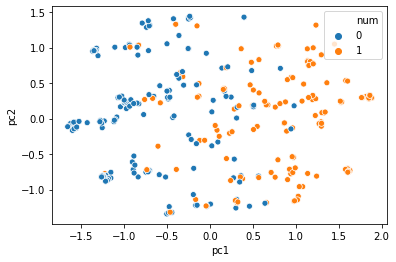

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_full)
X_tf = pca.transform(X_full)

dfpc = pd.DataFrame(data=X_tf, columns=['pc1', 'pc2'])
dfpc = pd.concat([dfpc, df_oh['num']], axis=1)

sns.scatterplot(x='pc1', y='pc2', hue='num', data=dfpc)

We observe that the samples without heart disease are more on the left of the plot, whereas the others tend to be more on the right. However, there is no clear boundary and many samples are overlapping, which indicates that it might be tough to get a clear decision boundary.

Now is the time to train models.

To find an appropriate classifier, we will simply try out a variety of different models. We will have both linear (e.g. Logistic Regression) and non-linear models (e.g. k-NN).

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

lr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC(C=0.5)
svm_lin = SVC(kernel='linear', C=2)
rf = RandomForestClassifier(n_estimators=20)

classifier_names = ['Logistic Regression', 'KNN', 'RBF SVM', 'Linear SVM', 'Random Forest']
classifiers = [lr, knn, svm, svm_lin, rf]

scores = []

# train
for clf, clf_name in zip(classifiers, classifier_names):
  scores_full = cross_val_score(clf, X_full, y, cv=5)
  scores_reduced = cross_val_score(clf, X_reduced, y, cv=5)
  for s_f, s_r in zip(scores_full, scores_reduced):
    d = {
         'classifier_name': clf_name,
         'score_full': s_f,
         'score_reduced': s_r
    }
    scores.append(d)

df_scores = pd.DataFrame(scores)
df_scores.head()

classifier_name  score_full  score_reduced
0  Logistic Regression    0.885246       0.868852
1  Logistic Regression    0.885246       0.918033
2  Logistic Regression    0.803279       0.819672
3  Logistic Regression    0.866667       0.883333
4  Logistic Regression    0.766667       0.800000

# 4. Evaluate models

Let us compare the models' performance.

As we have used 5-fold cross validation, we will inspect the distribution of scores over the folds. A high variance is indicative of overfitting the training data and suggests using more regularization or a simpler model.


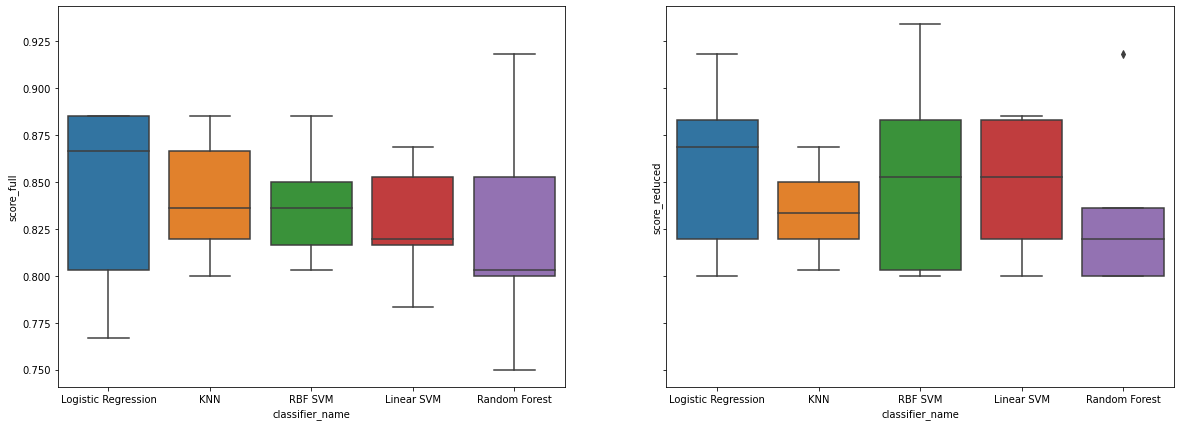

In [47]:
_, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
axes = axes.ravel()

sns.boxplot(x='classifier_name', y='score_full', data=df_scores, ax=axes[0])
sns.boxplot(x='classifier_name', y='score_reduced', data=df_scores, ax=axes[1])

In [44]:
df_scores.groupby(by='classifier_name').describe()

score_full            ... score_reduced          
                         count      mean  ...           75%       max
classifier_name                           ...                        
KNN                        5.0  0.841530  ...      0.850000  0.868852
Linear SVM                 5.0  0.828197  ...      0.883333  0.885246
Logistic Regression        5.0  0.841421  ...      0.883333  0.918033
RBF SVM                    5.0  0.838251  ...      0.883333  0.934426
Random Forest              5.0  0.831475  ...      0.850000  0.868852

[5 rows x 16 columns]

The accuracy of most classifiers is in the range of 80% to 90%, with Logistic Regression and RBF SVM slightly ahead.

We trained either with all features (`score_full`) or without the features we assumed to be least relevant (`score_reduced`).
Both conditions in fact give relatively similar results, which supports the hypothesis that the discarded features are indeed not very helpful to diagnose heart disease.

Further steps for improvement could be:
- Tune hyperparameters of the models
- Try other normalization procedure (e.g. mean/std instead of min/max)
  - in fact I tried: it gives relatively similar results, but most accuracies are slightly lower
  - it seems that min-max-normalization is ok here
- Use PCA for dimensionality reduction and train models with reduced features